In [ ]:
############ INSTALL PACKAGES #######################
!pip install matplotlib
!pip install seaborn

In [2]:
##########################################################
# 1. IMPORT ALL PACKAGES
##########################################################
import pandas as pd
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
import math
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt #for plotting
from sklearn.ensemble import RandomForestClassifier
# importing mean()
from statistics import mean

In [3]:
############### Download Train and Test Data ############################################
import boto3
s3 = boto3.client("s3", region_name='ap-south-1')
s3.download_file("kubeflow-ds-test-raw-lake", "data/train.csv", "data/train.csv")
s3.download_file("kubeflow-ds-test-raw-lake", "data/test.csv", "data/test.csv")

In [4]:
###################### EDA #################################################################
import pandas as pd
df_train = pd.read_csv("data/train.csv",header=0)
df_test = pd.read_csv("data/test.csv",header=0)

All labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Counter({1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795})


<AxesSubplot:xlabel='label', ylabel='count'>

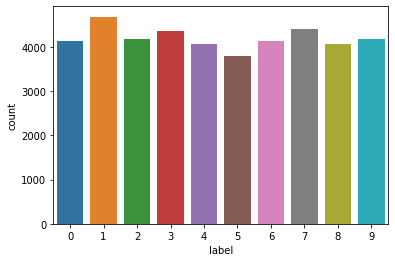

In [5]:
# Check all classes/labels in trainiing data
all_label = set(df_train['label'].tolist())
print("All labels: {0}".format(all_label))

# Data distribution for each class
dst_train = Counter(df_train['label'])
print(dst_train)

# Plot distribution
sns.countplot(x=df_train['label'])

In [12]:
print(df_train.shape)
x = df_train.iloc[:, 1:]
y = df_train['label'].tolist()
print(x.shape)
# # Select 10000 rows data as a testing dataset
x_test = x.iloc[0:10000, :].values.astype('float32') # all pixel values 
y_test = y[0:10000] # Select label for testing data
x_train = x.iloc[10000:, :].values.astype('float32') # all pixel values 
y_train = y[10000:]

(42000, 785)
(42000, 784)


In [7]:
print((min(x_train[2]), max(x_train[2])))

# Normalizing the data
x_train = x_train/255.0
x_test = x_test/255.0

# Printing the shape of the Datasets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

(0.0, 255.0)
x_train shape: (32000, 784)
32000 train samples
10000 test samples


In [8]:
depth = 8
n_estimators = 100
random_state = 0
print(x_train.shape, y_train.shape)
model_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=random_state)

# Train the Random Forest algorithm
model_clf.fit(x_train, y_train)

AttributeError: 'list' object has no attribute 'shape'

In [8]:
y_pred = model_clf.predict(x_test)

In [9]:
total = len(y_pred)
wrong = 0
for pred, truth in zip(y_pred, y_test):
    wrong += 1 if pred != truth else 0

accuracy = (total - wrong)/total

In [199]:
########## log model ####################
import mlflow
from mlflow.models.signature import infer_signature

mlflow.set_tracking_uri("http://mlflow-service.kubeflow.svc.cluster.local:80")
mlflow.set_experiment("mnist_rf_clf")

with mlflow.start_run() as run:
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", depth)
    mlflow.log_param("random_state", random_state)
    mlflow.log_metric("accuracy", accuracy)
    
    signature = infer_signature(x_train, y_pred)
    print(signature)
    
#     mlflow.sklearn.log_model(model_clf, "model", registered_model_name="MNIST_RF_CLF", signature=signature)
    
#     model_artifact_location = run.info.artifact_uri + "/model"
#     logged_model = 'runs:/'+run.info.run_id+'/model'

inputs: 
  [Tensor('float32', (-1, 784))]
outputs: 
  [Tensor('int64', (-1,))]



In [180]:
############### load model and deploy ########################
print(logged_model)
import boto3
import sagemaker
import pandas as pd
import numpy as np

import botocore.config

region = 'ap-south-1'

config = botocore.config.Config(
    user_agent_extra='dsoaws/1.0'
)
bsession = boto3.Session(region_name=region)
sm = bsession.client(service_name="sagemaker", 
                            region_name=region,
                            config=config)
sess = sagemaker.Session(boto_session=bsession, sagemaker_client=sm)
role = sagemaker.get_execution_role(sagemaker_session=sess)

import mlflow.sagemaker
mlflow.set_tracking_uri("http://mlflow-service.kubeflow.svc.cluster.local:80")
mlflow.set_experiment("Default")

mlflow.sagemaker.deploy(
    app_name='rf-mnist', #also the endpoint name
    model_uri=logged_model,
    image_url='369737379577.dkr.ecr.ap-south-1.amazonaws.com/mlflow-pyfunc:1.21.0',
    execution_role_arn=role,
    region_name=region, 
    mode='replace',
    instance_type='ml.m4.xlarge', 
    instance_count=1)

runs:/7b681060cede4505978d09e951392f97/model


2021/11/23 10:47:51 INFO mlflow.sagemaker: Using the python_function flavor for deployment!
2021/11/23 10:47:51 INFO mlflow.sagemaker: No model data bucket specified, using the default bucket
2021/11/23 10:47:53 INFO mlflow.sagemaker: Default bucket `mlflow-sagemaker-ap-south-1-369737379577` already exists. Skipping creation.
2021/11/23 10:47:57 INFO mlflow.sagemaker: tag response: {'ResponseMetadata': {'RequestId': 'SNK4NM26DM26YEVG', 'HostId': 'UHKRbWGjsgnCtLakGvEoPIl7zVFDkjpqxF/UJO1/2N2w6z0WNc6CWB82WMic7nyUATU01nKo8lw=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'UHKRbWGjsgnCtLakGvEoPIl7zVFDkjpqxF/UJO1/2N2w6z0WNc6CWB82WMic7nyUATU01nKo8lw=', 'x-amz-request-id': 'SNK4NM26DM26YEVG', 'date': 'Tue, 23 Nov 2021 10:47:58 GMT', 'server': 'AmazonS3', 'content-length': '0'}, 'RetryAttempts': 0}}
2021/11/23 10:47:57 INFO mlflow.sagemaker: Found active endpoint with arn: arn:aws:sagemaker:ap-south-1:369737379577:endpoint/rf-mnist. Updating...
2021/11/23 10:47:58 INFO mlflow.sagemaker

In [200]:
####################################################### Test the Deployment ##############################################################
import boto3
import pandas as pd
import botocore

region = 'ap-south-1'

config = botocore.config.Config(
    user_agent_extra='dsoaws/1.0'
)
# create sagemaker client using boto3
bsession = boto3.Session(region_name=region)
client = bsession.client(service_name="sagemaker-runtime", 
                            region_name=region,
                            config=config)

request_body = {
    "instances":[
        {
            "features": pd.DataFrame(x_test[0:1]).astype('float32')
        }
     ]
}
content_type = 'application/json'
# Make call to endpoint
response = client.invoke_endpoint(
    EndpointName='rf-mnist',
    ContentType=content_type,
    Body=request_body
    )

print("Returned:")
print(response['Body'].read().decode())


# content_type = "text/csv"
# # Make call to endpoint
# response = client.invoke_endpoint(
#     EndpointName='rf-mnist',
#     ContentType=content_type,
#     Body=open('sample3.csv', 'rb')
#     )

# print("Returned:")
# print(response['Body'].read().decode())

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: {'instances': [{'features':    0    1    2    3    4    5    6    7    8    9    ...  774  775  776  777  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   778  779  780  781  782  783  
0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 784 columns]}]}, type: <class 'dict'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [191]:
pd.DataFrame(x_test[0:1]).astype('float32').to_csv('sample3.csv')

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
